# Analysis of budgetary values in notices

In [1]:
import math
from dataclasses import dataclass
from functools import reduce
from typing import Any

import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

## Data model definition

In [2]:
@dataclass(frozen=True)
class MonetaryValue:
    value: str | None
    currency: str | None


@dataclass(frozen=True)
class MonetaryRange:
    low: MonetaryValue
    high: MonetaryValue


@dataclass(frozen=True)
class ObjectMonetaryValues:
    lot_id: str | None
    values: tuple[MonetaryValue]


@dataclass(frozen=True)
class ObjectMonetaryRange:
    lot_id: str | None
    ranges: MonetaryRange


@dataclass(frozen=True)
class BudgetaryNotice:
    notice_id: str
    notice_type: str
    publication_date: str
    reference_notice_id: str
    version: str
    object_contract_estimated_total_value: list[MonetaryValue]
    object_contract_total_value: list[MonetaryValue]
    object_contract_range_total_value: list[MonetaryRange]
    award_contract_estimated_total_value: list[MonetaryValue]
    award_contract_total_value: list[MonetaryValue]
    award_contract_range_total_value: list[MonetaryRange]
    object_value: list[ObjectMonetaryValues]
    contract_initial_estimated_total_value: list[MonetaryValue]
    quantity_range_total_value: list[ObjectMonetaryRange]

## Dataset loading

In [3]:
notice_type_to_parent = {
    "Call for expressions of interest": "Prior Information Notice",
    "Prior Information Notice": "Prior Information Notice",
    "Prior information notice with call for competition": "Prior Information Notice",
    "Periodic indicative notice with call for competition": "Prior Information Notice",
    "Prior information notice without call for competition": "Prior Information Notice",
    "Contract notice": "Contract Notice",
    "Prequalification notices": "Contract Notice",
    "General information": "Contract Notice",
    "Public works concession": "Contract Notice",
    "Services concession": "Contract Notice",
    "Request for proposals": "Contract Notice",
    "Not applicable": "Contract Notice",
    "Dynamic purchasing system": "Contract Notice",
    "Contract award": "Contract Award Notice",
    "Concession award notice": "Contract Award Notice",
    "Contract award notice": "Contract Award Notice",
    "Additional information": "Change Notice",
    "Corrigenda": "Change Notice",
    "Corrigendum": "Change Notice",
    "Modification of a contract/concession during its term": "Change Notice",
}

In [5]:
def parse_notice_id(notice_id: str) -> str:
    return f"{notice_id.split('-')[-1]}-{notice_id.split('/')[0]}" if notice_id else ""


df = pd.read_csv("tmp/20230601-notice-budgetary-values.csv", dtype="string")
df = df.fillna("")
df["reference_notice_id"] = df["reference_notice_id"].apply(parse_notice_id)
df["main_notice_type"] = df["notice_type"].apply(lambda x: notice_type_to_parent.get(x))
for column in df.columns:
    if column.endswith("_value"):
        df[column] = df[column].apply(lambda x: eval(x))
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44300 entries, 0 to 44299
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   notice_id                               44300 non-null  string
 1   notice_type                             44300 non-null  string
 2   publication_date                        44300 non-null  string
 3   reference_notice_id                     44300 non-null  object
 4   version                                 44300 non-null  string
 5   object_contract_estimated_total_value   44300 non-null  object
 6   object_contract_total_value             44300 non-null  object
 7   object_contract_range_total_value       44300 non-null  object
 8   award_contract_estimated_total_value    44300 non-null  object
 9   award_contract_total_value              44300 non-null  object
 10  award_contract_range_total_value        44300 non-null  object
 11  ob

notice_id             notice_type publication_date reference_notice_id  \
0  260146-2021         Contract notice         20210525         114530-2021   
1  448671-2015         Contract notice         20151222                       
2  450794-2016   Contract award notice         20161222                       
3  064176-2015         Contract notice         20150224                       
4  181172-2020  Additional information         20200420         105610-2020   

          version              object_contract_estimated_total_value  \
0  R2.0.9.S04.E01  [MonetaryValue(value='15200000.00', currency='...   
1  R2.0.8.S02.E01                                                 []   
2  R2.0.9.S01.E01                                                 []   
3  R2.0.8.S02.E01                                                 []   
4  R2.0.8.S04.E01                                                 []   

                         object_contract_total_value  \
0                                                 []   
1                                                 []   
2  [MonetaryValue(value='220100.00', currency='EU...   
3                                                 []   
4                                                 []   

  object_contract_range_total_value award_contract_estimated_total_value  \
0                                []                                   []   
1                                []                                   []   
2                                []                                   []   
3                                []                                   []   
4                                []                                   []   

                          award_contract_total_value  \
0                                                 []   
1                                                 []   
2  [MonetaryValue(value='220100.00', currency='EU...   
3                                                 []   
4                                                 []   

  award_contract_range_total_value  \
0                               []   
1                               []   
2                               []   
3                               []   
4                               []   

                                        object_value  \
0  [ObjectMonetaryValues(lot_id=None, values=(Mon...   
1                                                 []   
2                                                 []   
3                                                 []   
4                                                 []   

  contract_initial_estimated_total_value  \
0                                     []   
1                                     []   
2                                     []   
3                                     []   
4                                     []   

                          quantity_range_total_value       main_notice_type  
0                                                 []        Contract Notice  
1                                                 []        Contract Notice  
2                                                 []  Contract Award Notice  
3  [ObjectMonetaryRange(lot_id=None, ranges=Monet...        Contract Notice  
4                                                 []          Change Notice

## Analysis per notice

### Presence of budgetary value

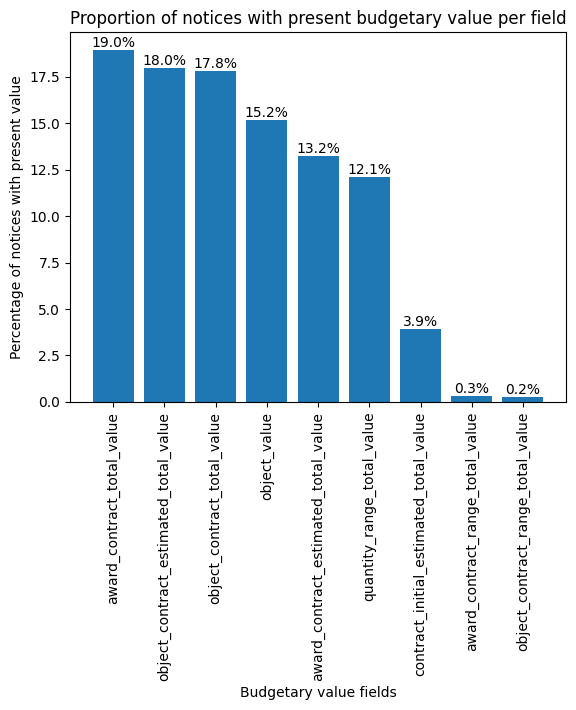

In [6]:
present_values_per_field = dict(sorted(
    {
        column: 100 * len(df[df[column].apply(len) > 0]) / len(df)
        for column in df.columns
        if column.endswith("_value")
    }.items(), key=lambda x: -x[1]
))
rects = plt.bar(present_values_per_field.keys(), present_values_per_field.values())
plt.bar_label(rects, fmt='%.1f%%')
plt.xticks(rotation=90)
plt.title("Proportion of notices with present budgetary value per field")
plt.xlabel("Budgetary value fields")
plt.ylabel("Percentage of notices with present value")
plt.show()

In [7]:
present_value_count = sum(df[c].apply(len) for c in df.columns if c.endswith("_value"))
present_value_notice_percent = 100 * len(df[present_value_count > 0]) / len(df)
print(f"{present_value_notice_percent:.2f}% of notices contain a budgetary value.")

49.85% of notices contain a budgetary value.


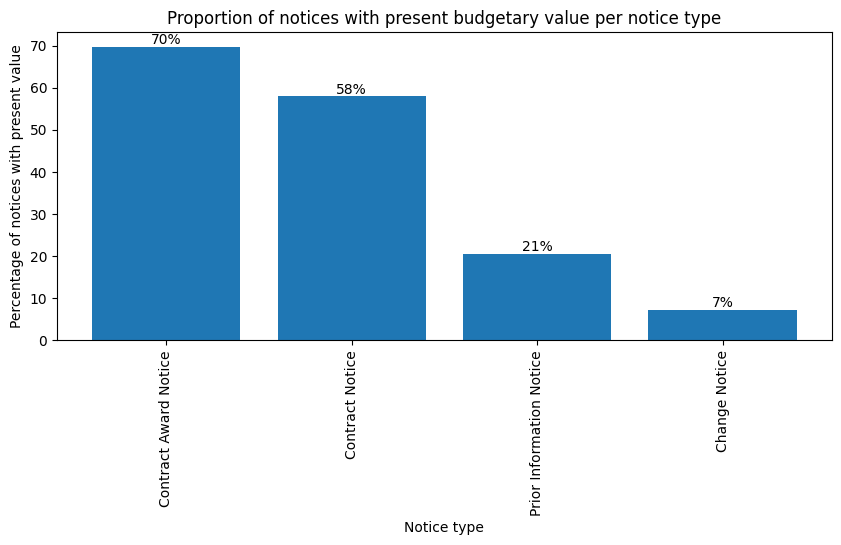

In [9]:
present_values_per_notice_type = dict(sorted(
    {
        notice_type: 100 *
                     len(df[(present_value_count > 0) & (
                             df["main_notice_type"] == notice_type)])
                     / len(df[(df["main_notice_type"] == notice_type)])
        for notice_type in df["main_notice_type"].unique()
        if len(df[(df["main_notice_type"] == notice_type)]) != 0
    }.items(), key=lambda x: -x[1]
))
plt.figure(figsize=(10, 4))
rects = plt.bar(present_values_per_notice_type.keys(), present_values_per_notice_type.values())
plt.bar_label(rects, fmt='%.0f%%')
plt.xticks(rotation=90)
plt.title("Proportion of notices with present budgetary value per notice type")
plt.xlabel("Notice type")
plt.ylabel("Percentage of notices with present value")
plt.show()

In [17]:
notice_types = [t for t, p in present_values_per_notice_type.items() if p > 0]
budgetary_value_fields = [c for c in df.columns if c.endswith("_value")]
harvest = [
    [
        100
        * len(df[(df[f].apply(len) > 0) & (df["main_notice_type"] == t)])
        / len(df[(df["main_notice_type"] == t)])
        for f in budgetary_value_fields
    ]
    for t in notice_types
]
plt.figure(figsize=(10, 5))
img = plt.imshow(harvest, cmap='winter', vmin=0.001)
img.cmap.set_under('black')
for i in range(len(notice_types)):
    for j in range(len(budgetary_value_fields)):
        color = 'w' if harvest[i][j] < 25 else 'black'
        text = plt.text(j, i, f"{harvest[i][j]:.1f}%", ha="center", va="center", color=color)
plt.colorbar()
plt.xticks(range(len(budgetary_value_fields)), labels=budgetary_value_fields,
           rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(range(len(notice_types)), labels=notice_types)
plt.title("Percentage of notices with present budgetary value field for each notice type")
plt.xlabel("Budgetary value field")
plt.ylabel("Notice type")
plt.show()

In [18]:
budgetary_value_fields = [c for c in df.columns if c.endswith("_value")]
harvest = [
    [
        len(df[(df[f1].apply(len) > 0) & (df[f2].apply(len) > 0)]) if i1 < i2 else -1
        for i2, f2 in enumerate(budgetary_value_fields)
    ]
    for i1, f1 in enumerate(budgetary_value_fields)
]
plt.figure(figsize=(8, 6))
img = plt.imshow(harvest, cmap='winter', vmin=0.001)
img.cmap.set_under('black')
for i in range(len(budgetary_value_fields)):
    for j in range(len(budgetary_value_fields)):
        color = 'w' if harvest[i][j] < 4000 else 'black'
        text = plt.text(j, i, harvest[i][j] if harvest[i][j] >= 0 else ".", ha="center", va="center", color=color)
plt.colorbar()
plt.xticks(range(len(budgetary_value_fields)), labels=budgetary_value_fields,
           rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(range(len(budgetary_value_fields)), labels=budgetary_value_fields)
plt.title("Number of notices containing pair of budgetary value fields")
plt.xlabel("Budgetary value field")
plt.ylabel("Budgetary value field")
plt.show()

### Repartition of currencies

In [19]:
value_fields = [
    "object_contract_estimated_total_value",
    "object_contract_total_value",
    "award_contract_estimated_total_value",
    "award_contract_total_value",
    "contract_initial_estimated_total_value",
]
range_fields = [
    "object_contract_range_total_value",
    "award_contract_range_total_value",
]
object_value_fields = [
    "object_value",
]
object_range_fields = [
    "quantity_range_total_value",
]

In [20]:
currencies = {
    "AED": "United Arab Emirates dirham",
    "AFN": "Afghan afghani",
    "ALL": "Albanian lek",
    "AMD": "Armenian dram",
    "ANG": "Netherlands Antillean guilder",
    "AOA": "Angolan kwanza",
    "ARS": "Argentine peso",
    "AUD": "Australian dollar",
    "AWG": "Aruban florin",
    "AZN": "Azerbaijani manat",
    "BAM": "Bosnia and Herzegovina convertible mark",
    "BBD": "Barbados dollar",
    "BDT": "Bangladeshi taka",
    "BGN": "Bulgarian lev",
    "BHD": "Bahraini dinar",
    "BIF": "Burundian franc",
    "BMD": "Bermudian dollar",
    "BND": "Brunei dollar",
    "BOB": "Boliviano",
    "BRL": "Brazilian real",
    "BSD": "Bahamian dollar",
    "BTN": "Bhutanese ngultrum",
    "BWP": "Botswana pula",
    "BYN": "New Belarusian ruble",
    "BYR": "Belarusian ruble",
    "BZD": "Belize dollar",
    "CAD": "Canadian dollar",
    "CDF": "Congolese franc",
    "CHF": "Swiss franc",
    "CLF": "Unidad de Fomento",
    "CLP": "Chilean peso",
    "CNY": "Renminbi|Chinese yuan",
    "COP": "Colombian peso",
    "CRC": "Costa Rican colon",
    "CUC": "Cuban convertible peso",
    "CUP": "Cuban peso",
    "CVE": "Cape Verde escudo",
    "CZK": "Czech koruna",
    "DJF": "Djiboutian franc",
    "DKK": "Danish krone",
    "DOP": "Dominican peso",
    "DZD": "Algerian dinar",
    "EGP": "Egyptian pound",
    "ERN": "Eritrean nakfa",
    "ETB": "Ethiopian birr",
    "EUR": "Euro",
    "FJD": "Fiji dollar",
    "FKP": "Falkland Islands pound",
    "GBP": "Pound sterling",
    "GEL": "Georgian lari",
    "GHS": "Ghanaian cedi",
    "GIP": "Gibraltar pound",
    "GMD": "Gambian dalasi",
    "GNF": "Guinean franc",
    "GTQ": "Guatemalan quetzal",
    "GYD": "Guyanese dollar",
    "HKD": "Hong Kong dollar",
    "HNL": "Honduran lempira",
    "HRK": "Croatian kuna",
    "HTG": "Haitian gourde",
    "HUF": "Hungarian forint",
    "IDR": "Indonesian rupiah",
    "ILS": "Israeli new shekel",
    "INR": "Indian rupee",
    "IQD": "Iraqi dinar",
    "IRR": "Iranian rial",
    "ISK": "Icelandic króna",
    "JMD": "Jamaican dollar",
    "JOD": "Jordanian dinar",
    "JPY": "Japanese yen",
    "KES": "Kenyan shilling",
    "KGS": "Kyrgyzstani som",
    "KHR": "Cambodian riel",
    "KMF": "Comoro franc",
    "KPW": "North Korean won",
    "KRW": "South Korean won",
    "KWD": "Kuwaiti dinar",
    "KYD": "Cayman Islands dollar",
    "KZT": "Kazakhstani tenge",
    "LAK": "Lao kip",
    "LBP": "Lebanese pound",
    "LKR": "Sri Lankan rupee",
    "LRD": "Liberian dollar",
    "LSL": "Lesotho loti",
    "LYD": "Libyan dinar",
    "MAD": "Moroccan dirham",
    "MDL": "Moldovan leu",
    "MGA": "Malagasy ariary",
    "MKD": "Macedonian denar",
    "MMK": "Myanmar kyat",
    "MNT": "Mongolian tögrög",
    "MOP": "Macanese pataca",
    "MRO": "Mauritanian ouguiya",
    "MUR": "Mauritian rupee",
    "MVR": "Maldivian rufiyaa",
    "MWK": "Malawian kwacha",
    "MXN": "Mexican peso",
    "MXV": "Mexican Unidad de Inversion",
    "MYR": "Malaysian ringgit",
    "MZN": "Mozambican metical",
    "NAD": "Namibian dollar",
    "NGN": "Nigerian naira",
    "NIO": "Nicaraguan córdoba",
    "NOK": "Norwegian krone",
    "NPR": "Nepalese rupee",
    "NZD": "New Zealand dollar",
    "OMR": "Omani rial",
    "PAB": "Panamanian balboa",
    "PEN": "Peruvian Sol",
    "PGK": "Papua New Guinean kina",
    "PHP": "Philippine peso",
    "PKR": "Pakistani rupee",
    "PLN": "Polish złoty",
    "PYG": "Paraguayan guaraní",
    "QAR": "Qatari riyal",
    "RON": "Romanian leu",
    "RSD": "Serbian dinar",
    "RUB": "Russian ruble",
    "RWF": "Rwandan franc",
    "SAR": "Saudi riyal",
    "SBD": "Solomon Islands dollar",
    "SCR": "Seychelles rupee",
    "SDG": "Sudanese pound",
    "SEK": "Swedish krona",
    "SGD": "Singapore dollar",
    "SHP": "Saint Helena pound",
    "SLL": "Sierra Leonean leone",
    "SOS": "Somali shilling",
    "SRD": "Surinamese dollar",
    "SSP": "South Sudanese pound",
    "STD": "São Tomé and Príncipe dobra",
    "SVC": "Salvadoran colón",
    "SYP": "Syrian pound",
    "SZL": "Swazi lilangeni",
    "THB": "Thai baht",
    "TJS": "Tajikistani somoni",
    "TMT": "Turkmenistani manat",
    "TND": "Tunisian dinar",
    "TOP": "Tongan paʻanga",
    "TRY": "Turkish lira",
    "TTD": "Trinidad and Tobago dollar",
    "TWD": "New Taiwan dollar",
    "TZS": "Tanzanian shilling",
    "UAH": "Ukrainian hryvnia",
    "UGX": "Ugandan shilling",
    "USD": "United States dollar",
    "UYI": "Uruguay Peso en Unidades Indexadas",
    "UYU": "Uruguayan peso",
    "UZS": "Uzbekistan som",
    "VEF": "Venezuelan bolívar",
    "VND": "Vietnamese đồng",
    "VUV": "Vanuatu vatu",
    "WST": "Samoan tala",
    "XAF": "Central African CFA franc",
    "XCD": "East Caribbean dollar",
    "XOF": "West African CFA franc",
    "XPF": "CFP franc",
    "YER": "Yemeni rial",
    "ZAR": "South African rand",
    "ZMW": "Zambian kwacha",
    "ZWL": "Zimbabwean dollar"
}

In [21]:
def notice_count_with_currency(currency: str) -> int:
    return (reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: any(i.currency == currency for i in l))
        for f in value_fields
    ]) | reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: any(i.low.currency == currency or i.high.currency == currency for i in l))
        for f in range_fields
    ]) | reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: any(any(v.currency == currency for v in i.values) for i in l))
        for f in object_value_fields
    ]) | reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: bool(l) and any(
            i.ranges.low.currency == currency or i.ranges.high.currency == currency
            for i in l
        ))
        for f in object_range_fields
    ])).sum()


notice_count_per_currency = {
    c: notice_count_with_currency(c)
    for c in currencies.keys()
}

In [22]:
filtered_notice_count_per_currency = dict(sorted(
    {
        k: v for k, v in notice_count_per_currency.items() if v
    }.items(), key=lambda x: -x[1]
))
plt.figure(figsize=(18, 4))
rects = plt.bar(filtered_notice_count_per_currency.keys(), filtered_notice_count_per_currency.values())
plt.bar_label(rects, fmt='%.0f')
plt.xticks(rotation=90)
plt.title("Number of notices per currency")
plt.xlabel("Currency")
plt.ylabel("Number of notices")
plt.show()

### Probably invalid budgetary values

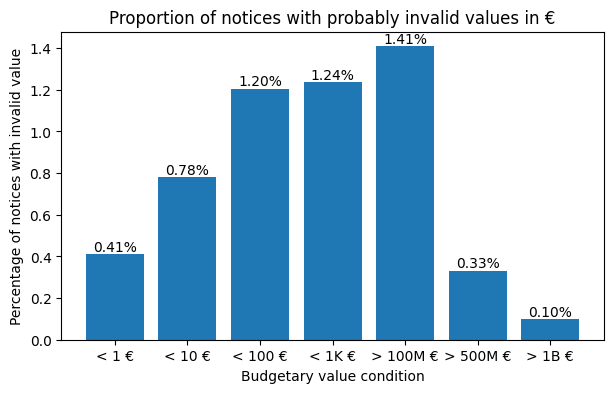

In [23]:
def notice_count_with_value_lower_than(value: float) -> int:
    return (reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: bool(l) and any(float(i.value) < value and i.currency == "EUR" for i in l))
        for f in value_fields
    ]) | reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: bool(l) and any(float(i.high.value) < value and i.high.currency == "EUR" for i in l))
        for f in range_fields
    ]) | reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: bool(l) and any(
            any(float(v.value) < value and v.currency == "EUR" for v in i.values)
            for i in l
        ))
        for f in object_value_fields
    ]) | reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: bool(l) and any(
            float(i.ranges.high.value or "0") < value and i.ranges.high.currency == "EUR"
            for i in l
        ))
        for f in object_range_fields
    ])).sum()


def notice_count_with_value_greater_than(value: float) -> int:
    return (reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: bool(l) and any(float(i.value) > value and i.currency == "EUR" for i in l))
        for f in value_fields
    ]) | reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: bool(l) and any(float(i.low.value) > value and i.low.currency == "EUR" for i in l))
        for f in range_fields
    ]) | reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: bool(l) and any(
            any(float(v.value) > value and v.currency == "EUR" for v in i.values)
            for i in l
        ))
        for f in object_value_fields
    ]) | reduce(lambda a, b: a | b, [
        df[f].apply(lambda l: bool(l) and any(
            float(i.ranges.low.value or "0") > value and i.ranges.low.currency == "EUR"
            for i in l
        ))
        for f in object_range_fields
    ])).sum()


total_count = len(df[present_value_count > 0])
notice_count = {
    '< 1 €': 100 * notice_count_with_value_lower_than(1) / total_count,
    '< 10 €': 100 * notice_count_with_value_lower_than(10) / total_count,
    '< 100 €': 100 * notice_count_with_value_lower_than(100) / total_count,
    '< 1K €': 100 * notice_count_with_value_lower_than(1000) / total_count,
    '> 100M €': 100 * notice_count_with_value_greater_than(100000000) / total_count,
    '> 500M €': 100 * notice_count_with_value_greater_than(500000000) / total_count,
    '> 1B €': 100 * notice_count_with_value_greater_than(1000000000) / total_count,
}
plt.figure(figsize=(7, 4))
rects = plt.bar(notice_count.keys(), notice_count.values())
plt.bar_label(rects, fmt='%.2f%%')
plt.xticks(rotation=0)
plt.title("Proportion of notices with probably invalid values in €")
plt.xlabel("Budgetary value condition")
plt.ylabel("Percentage of notices with invalid value")
plt.show()

In [24]:
def flatten(list_: list[list]) -> list:
    return [j for i in list_ for j in i]


def all_values(field: str, min_: float, max_: float, with_lots: float):
    if field in value_fields:
        values = df[field].apply(
            lambda l: [float(i.value) for i in l if i.currency == "EUR" and min_ <= float(i.value) <= max_]
        )
    elif field in range_fields:
        values = df[field].apply(
            lambda l: [
                          float(i.low.value)
                          for i in l
                          if i.low.currency == "EUR" and min_ <= float(i.low.value) <= max_
                      ]
                      + [
                          float(i.high.value)
                          for i in l
                          if i.high.currency == "EUR" and min_ <= float(i.high.value) <= max_
                      ]
        )
    elif field in object_value_fields:
        values = df[field].apply(
            lambda l: flatten([
                [float(v.value) for v in i.values if v.currency == "EUR" and min_ <= float(v.value) <= max_]
                for i in l
                if (i.lot_id is None or with_lots)
            ])
        )
    else:
        values = df[field].apply(
            lambda l: [
                          float(r.ranges.low.value or "0")
                          for r in l
                          if
                          r.ranges.low.currency == "EUR"
                          and min_ <= float(r.ranges.low.value) <= max_ and (r.lot_id is None or with_lots)
                      ] + [
                          float(r.ranges.high.value or "0")
                          for r in l
                          if r.ranges.high.currency == "EUR"
                             and min_ <= float(r.ranges.high.value) <= max_ and (r.lot_id is None or with_lots)
                      ]
        )
    return flatten(values)

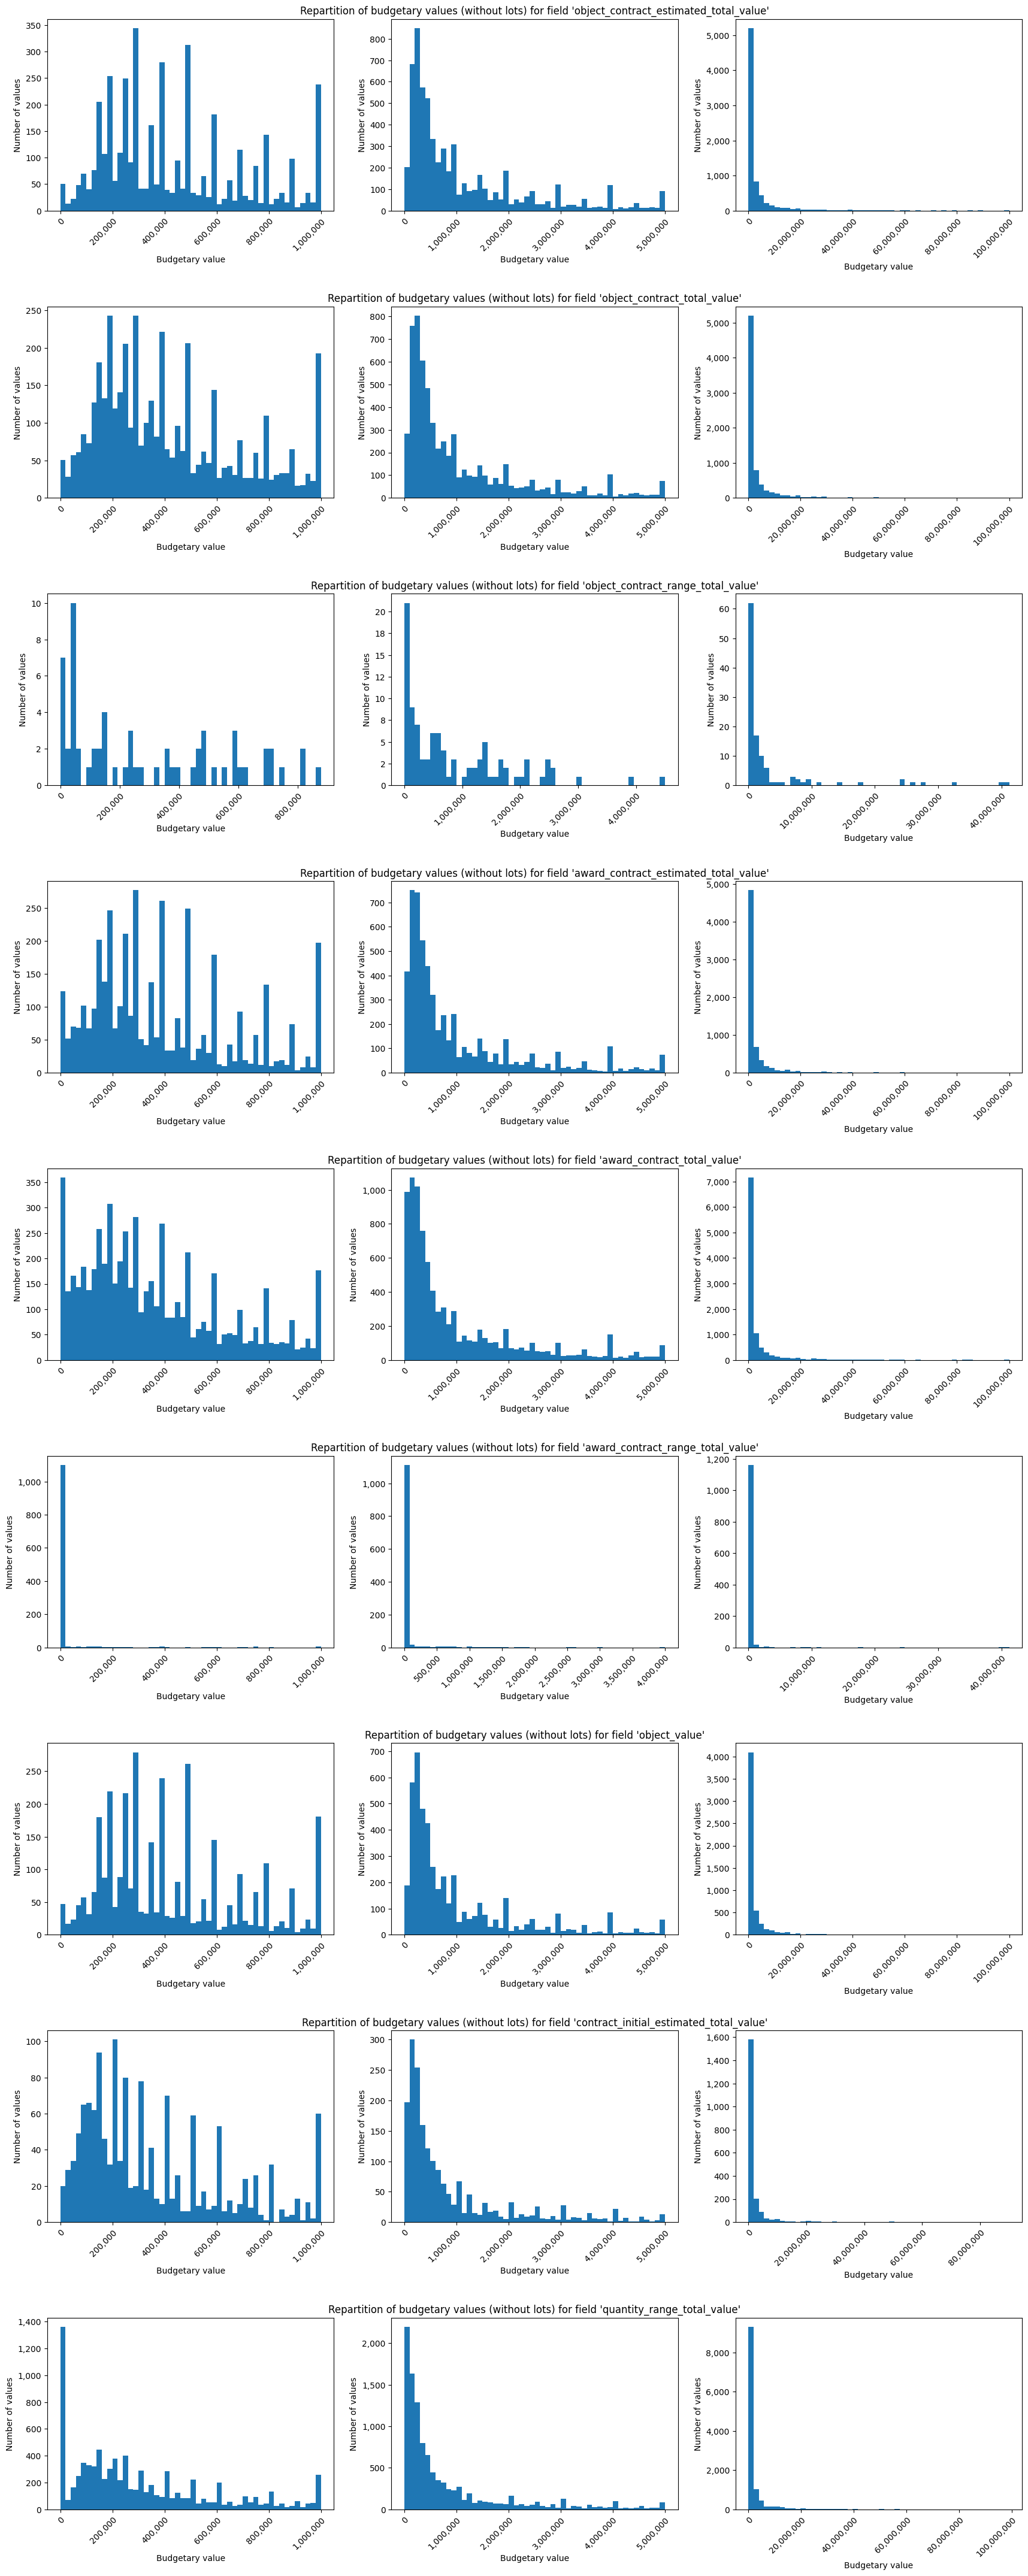

In [25]:
params = [
    (c, r)
    for c in df.columns if c.endswith("_value")
    for r in ((0, 1000000), (0, 5000000), (0, 100000000))
]
width_figure_count = 3
height_figure_count = math.ceil(len(params) / width_figure_count)

gs = GridSpec(height_figure_count, width_figure_count)
plt.figure(figsize=(width_figure_count * 7, height_figure_count * 6))
plt.subplots_adjust(hspace=0.5)
for fig_id, (field, (min_, max_)) in enumerate(params):
    values = all_values(field, min_, max_, with_lots=False)
    plt.subplot(gs[int(fig_id / width_figure_count), int(fig_id % width_figure_count)])
    plt.hist(values, bins=50)
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x):,.0f}"))
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f"{y:,.0f}"))
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    if fig_id % 3 == 1:
        plt.title(f"Repartition of budgetary values (without lots) for field '{field}'")
    plt.xlabel("Budgetary value")
    plt.ylabel("Number of values")
plt.show()

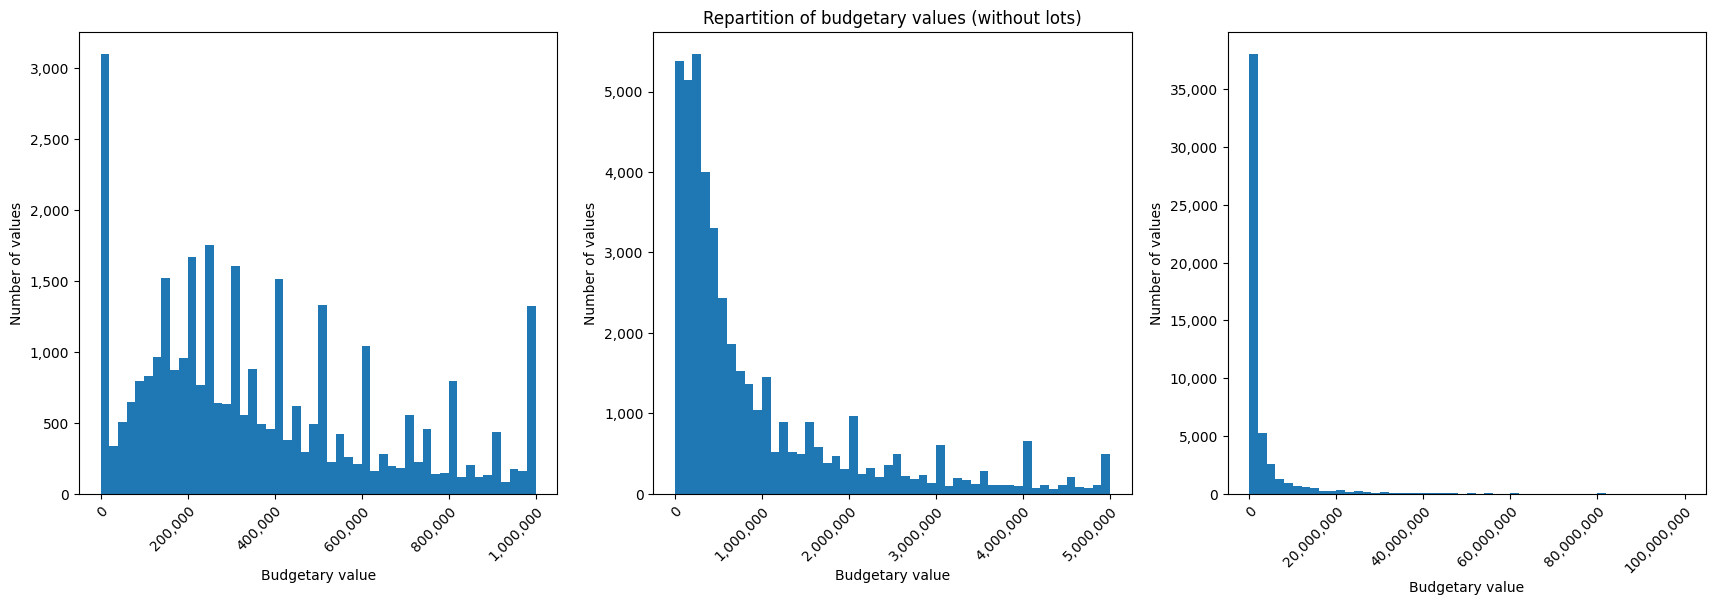

In [26]:
params = ((0, 1000000), (0, 5000000), (0, 100000000))
width_figure_count = 3
height_figure_count = math.ceil(len(params) / width_figure_count)

gs = GridSpec(height_figure_count, width_figure_count)
plt.figure(figsize=(width_figure_count * 7, height_figure_count * 6))
plt.subplots_adjust(hspace=0.5)
for fig_id, (min_, max_) in enumerate(params):
    values = flatten([
        all_values(c, min_, max_, with_lots=False)
        for c in df.columns if c.endswith("_value")
    ])
    plt.subplot(gs[int(fig_id / width_figure_count), int(fig_id % width_figure_count)])
    plt.hist(values, bins=50)
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x:,.0f}"))
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f"{y:,.0f}"))
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    if fig_id % 3 == 1:
        plt.title(f"Repartition of budgetary values (without lots)")
    plt.xlabel("Budgetary value")
    plt.ylabel("Number of values")
plt.show()

In [27]:
def flatten(list_: list[list]) -> list:
    return [j for i in list_ for j in i]


def all_values(field: str, with_lots: float):
    if field in value_fields:
        values = df[field].apply(
            lambda l: [float(i.value) for i in l if i.currency == "EUR"]
        )
    elif field in range_fields:
        values = df[field].apply(
            lambda l: [
                          float(i.low.value)
                          for i in l
                          if i.low.currency == "EUR"
                      ]
                      + [
                          float(i.high.value)
                          for i in l
                          if i.high.currency == "EUR"
                      ]
        )
    elif field in object_value_fields:
        values = df[field].apply(
            lambda l: flatten([
                [float(v.value) for v in i.values if v.currency == "EUR"]
                for i in l
                if (i.lot_id is None or with_lots)
            ])
        )
    else:
        values = df[field].apply(
            lambda l: [
                          float(r.ranges.low.value or "0")
                          for r in l
                          if
                          r.ranges.low.currency == "EUR"
                          and (r.lot_id is None or with_lots)
                      ] + [
                          float(r.ranges.high.value or "0")
                          for r in l
                          if r.ranges.high.currency == "EUR"
                             and (r.lot_id is None or with_lots)
                      ]
        )
    return flatten(values)

In [30]:
invalid_range_count = (reduce(lambda a, b: a | b, [
    df[f].apply(lambda l: bool(l) and any(float(i.high.value) < float(i.low.value) for i in l))
    for f in range_fields
]) | reduce(lambda a, b: a | b, [
    df[f].apply(lambda l: bool(l) and any(
        float(i.ranges.high.value or "0") < float(i.ranges.low.value or "0")
        for i in l
    ))
    for f in object_range_fields
])).sum()
print(f"{invalid_range_count} notices with invalid range (high < low)")

0 notices with invalid range (high < low)


In [31]:
none_value_count = (reduce(lambda a, b: a | b, [
    df[f].apply(lambda l: bool(l) and any(i.value is None for i in l))
    for f in value_fields
]) | reduce(lambda a, b: a | b, [
    df[f].apply(lambda l: bool(l) and any(i.low.value is None or i.high.value is None for i in l))
    for f in range_fields
]) | reduce(lambda a, b: a | b, [
    df[f].apply(lambda l: bool(l) and any(any(v.value is None for v in i.values) for i in l))
    for f in object_value_fields
]) | reduce(lambda a, b: a | b, [
    df[f].apply(lambda l: bool(l) and any(
        i.ranges.low.value is None or i.ranges.high.value is None
        for i in l
    ))
    for f in object_range_fields
])).sum()
print(f"{none_value_count} notices have unspecified value")

1 notices have unspecified value


In [32]:
unknown_currency_count = (reduce(lambda a, b: a | b, [
    df[f].apply(lambda l: any(i.currency not in currencies.keys() for i in l))
    for f in value_fields
]) | reduce(lambda a, b: a | b, [
    df[f].apply(lambda l: any(
        i.low.currency not in currencies.keys() or i.high.currency not in currencies.keys()
        for i in l
    ))
    for f in range_fields
]) | reduce(lambda a, b: a | b, [
    df[f].apply(lambda l: any(any(v.currency not in currencies.keys() for v in i.values) for i in l))
    for f in object_value_fields
]) | reduce(lambda a, b: a | b, [
    df[f].apply(lambda l: bool(l) and any(
        i.ranges.low.currency not in currencies.keys() or i.ranges.high.currency not in currencies.keys()
        for i in l
    ))
    for f in object_range_fields
])).sum()
print(f"{unknown_currency_count} notices have unknown currency")

0 notices have unknown currency


### Mismatching object_value and object_contract_estimated_total_value

In [67]:
df["object_value_lot_total"] = df["object_value"].apply(lambda l: sum(
    sum(float(v.value) for v in r.values) for r in l if r.lot_id
))
df["object_value_contract_total"] = df["object_value"].apply(lambda l: sum(
    sum(float(v.value) for v in r.values) for r in l if not r.lot_id
))
df["object_contract_estimated_total"] = df["object_contract_estimated_total_value"].apply(lambda l: sum(
    float(v.value) for v in l
))

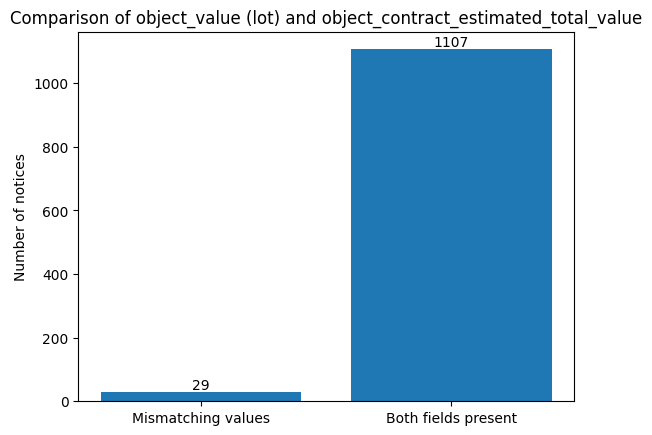

In [68]:
results = {
    f"Mismatching values": (
            ((df["object_value_lot_total"] - df["object_contract_estimated_total"]) > 0.001)
            & (df["object_value_lot_total"] != 0)
            & (df["object_contract_estimated_total"] != 0)).sum(),
    "Both fields present": (
            (df["object_value_lot_total"] != 0) & (df["object_contract_estimated_total"] != 0)).sum(),
}
rects = plt.bar(results.keys(), results.values())
plt.bar_label(rects)
plt.title("Comparison of object_value (lot) and object_contract_estimated_total_value")
plt.ylabel("Number of notices")
plt.show()

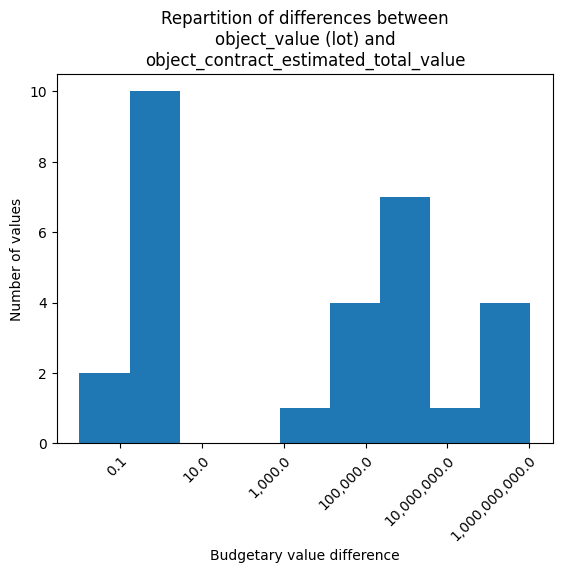

In [69]:

wrong_lines = df[((df["object_value_lot_total"] - df["object_contract_estimated_total"] > 0.001)
                  & (df["object_value_lot_total"] != 0) & (df["object_contract_estimated_total"] != 0))].copy()
wrong_lines["diff_str"] = (wrong_lines["object_value_lot_total"]
                           - wrong_lines["object_contract_estimated_total"]).abs().apply(lambda d: f"{d:.2f}")
values = wrong_lines["diff_str"].apply(float)
plt.hist(values, bins=np.logspace(np.log10(values.min()), np.log10(values.max()), 10))
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x:,.1f}"))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f"{y:,.0f}"))
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.title(f"Repartition of differences between\nobject_value (lot) and\nobject_contract_estimated_total_value")
plt.xlabel("Budgetary value difference")
plt.ylabel("Number of values")
plt.show()

In [70]:
results = {
    f"Mismatching values": (
            ((df["object_value_contract_total"] - df["object_contract_estimated_total"]) > 0.001)
            & (df["object_value_contract_total"] != 0)
            & (df["object_contract_estimated_total"] != 0)).sum(),
    "Both fields present": (
            (df["object_value_contract_total"] != 0) & (df["object_contract_estimated_total"] != 0)).sum(),
}
rects = plt.bar(results.keys(), results.values())
plt.bar_label(rects)
plt.title("Comparison of object_value (contract) and object_contract_estimated_total_value")
plt.ylabel("Number of notices")
plt.show()

In [71]:
wrong_lines = df[((df["object_value_contract_total"] - df["object_contract_estimated_total"] > 0.001)
                  & (df["object_value_contract_total"] != 0) & (df["object_contract_estimated_total"] != 0))].copy()
wrong_lines["diff_str"] = (wrong_lines["object_value_contract_total"]
                           - wrong_lines["object_contract_estimated_total"]).abs().apply(lambda d: f"{d:.2f}")
values = wrong_lines["diff_str"].apply(float)
plt.hist(values, bins=np.logspace(np.log10(values.min()), np.log10(values.max()), 10))
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x:,.1f}"))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f"{y:,.0f}"))
plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.title(f"Repartition of differences between\nobject_value (contract) and\nobject_contract_estimated_total_value")
plt.xlabel("Budgetary value difference")
plt.ylabel("Number of values")
plt.show()

### Mismatching between value fields

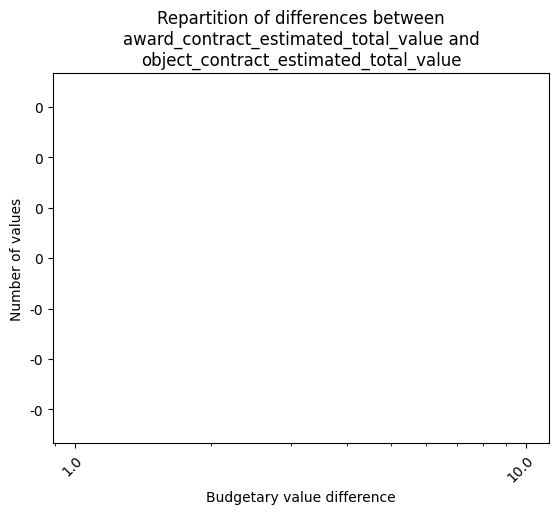

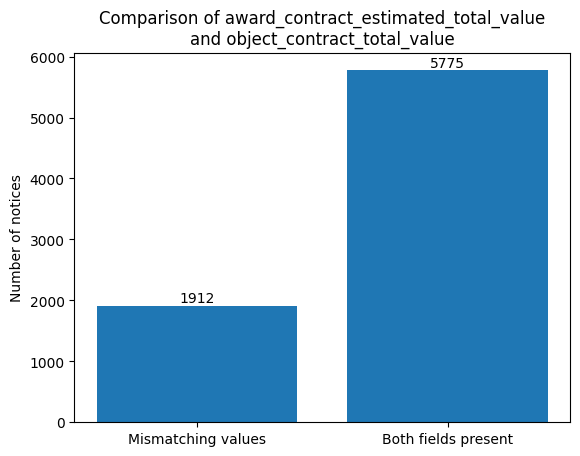

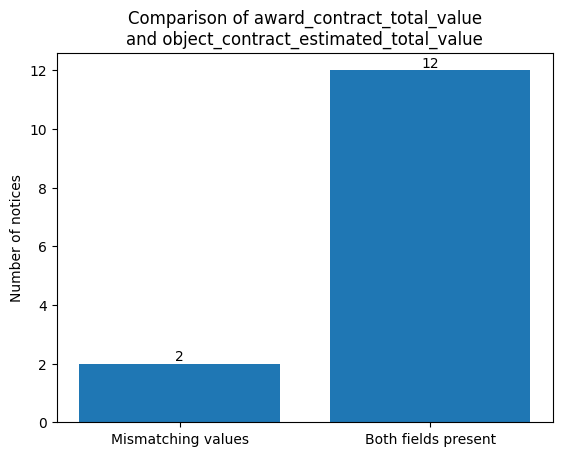

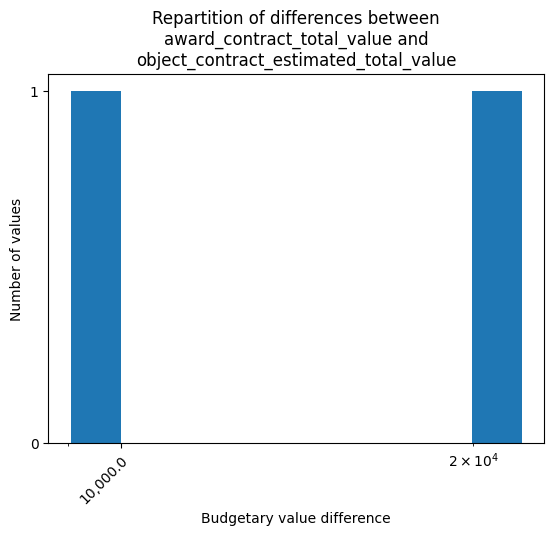

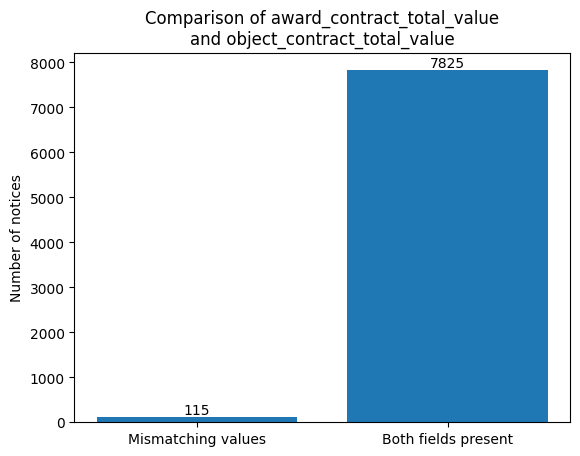

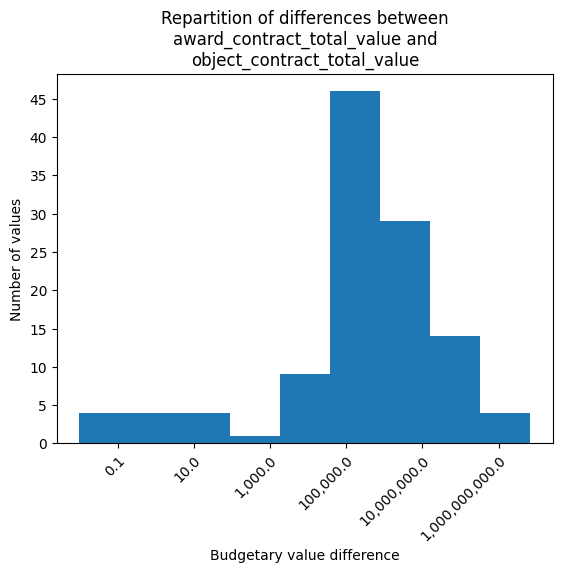

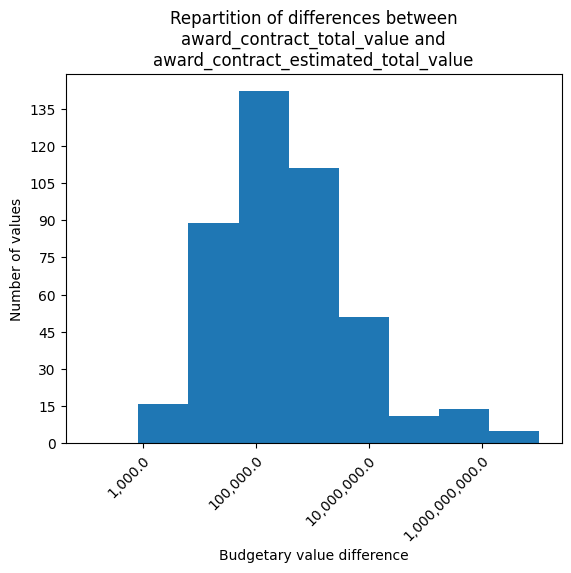

In [72]:
params = [(f1, f2) for i1, f1 in enumerate(value_fields) for i2, f2 in enumerate(value_fields) if i2 < i1]

for f1, f2 in params:
    df["total_1"] = df[f1].apply(lambda l: sum(float(v.value) for v in l))
    df["total_2"] = df[f2].apply(lambda l: sum(float(v.value) for v in l))
    results = {
        f"Mismatching values": (
                ((df["total_1"] - df["total_2"]) > 0.001)
                & (df["total_1"] != 0)
                & (df["total_2"] != 0)).sum(),
        "Both fields present": ((df["total_1"] != 0) & (df["total_2"] != 0)).sum(),
    }
    if results["Both fields present"] == 0:
        continue
    rects = plt.bar(results.keys(), results.values())
    plt.bar_label(rects)
    plt.title(f"Comparison of {f1}\nand {f2}")
    plt.ylabel("Number of notices")
    plt.show()

    wrong_lines = df[((df["total_1"] - df["total_2"] > 0.001)
                      & (df["total_1"] != 0) & (df["total_2"] != 0))].copy()
    wrong_lines["diff_str"] = (wrong_lines["total_1"]
                               - wrong_lines["total_2"]).abs().apply(lambda d: f"{d:.2f}")
    values = wrong_lines["diff_str"].apply(float)
    plt.hist(values, bins=np.logspace(np.log10(values.min()), np.log10(values.max()), 10))
    plt.xscale('log')
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x:,.1f}"))
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f"{y:,.0f}"))
    plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.title(f"Repartition of differences between\n{f1} and\n{f2}")
    plt.xlabel("Budgetary value difference")
    plt.ylabel("Number of values")
    plt.show()

## Procurement dataset creation

In [90]:
def find_first_ref_number(ref_notice_number: str | float, number_to_ref: dict[str, str]) -> str | None:
    if not ref_notice_number:
        return None
    inner_ref_notice_number = number_to_ref.get(ref_notice_number)
    if not inner_ref_notice_number:
        return ref_notice_number
    return find_first_ref_number(inner_ref_notice_number, number_to_ref)


def aggregate(series: pd.Series) -> Any:
    values = list(filter(None, iter(series)))
    if not values:
        return None
    if isinstance(values[0], float):
        return values[-1]
    if isinstance(values[0], list):
        return values[-1]
    if isinstance(values[0], str):
        return ",".join(values)
    raise RuntimeError(f"type not supported: {type(values[0])}")


number_to_ref = dict(zip(df["notice_id"], df["reference_notice_id"]))
cleaned_df = df.drop([c for c in df.columns if c.endswith("_total") or c.startswith("total_")], axis=1)
cleaned_df["main_reference_notice_id"] = cleaned_df["reference_notice_id"].apply(
    find_first_ref_number, args=(number_to_ref,))
proc_df = cleaned_df.sort_values("publication_date").groupby("main_reference_notice_id").agg(aggregate)

In [91]:
proc_df.info()
proc_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 13462 entries, 000001-2015 to 732638-2022
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   notice_id                               13462 non-null  string
 1   notice_type                             13462 non-null  string
 2   publication_date                        13462 non-null  string
 3   reference_notice_id                     13462 non-null  object
 4   version                                 13459 non-null  string
 5   object_contract_estimated_total_value   728 non-null    object
 6   object_contract_total_value             6175 non-null   object
 7   object_contract_range_total_value       81 non-null     object
 8   award_contract_estimated_total_value    4920 non-null   object
 9   award_contract_total_value              6231 non-null   object
 10  award_contract_range_total_value        115 non-null    obj

notice_id  \
main_reference_notice_id                                                      
000001-2015                                                     291575-2015   
000001-2017                                                     396629-2017   
000001-2018                                                     027739-2018   
000001-2022                                                     561201-2022   
000002-2014               043921-2014,096361-2014,322125-2014,332867-201...   

                                                                notice_type  \
main_reference_notice_id                                                      
000001-2015                                           Contract award notice   
000001-2017                                           Contract award notice   
000001-2018                                          Additional information   
000001-2022                                           Contract award notice   
000002-2014               Contract notice,Additional information,Additio...   

                                                           publication_date  \
main_reference_notice_id                                                      
000001-2015                                                        20150819   
000001-2017                                                        20171007   
000001-2018                                                        20180120   
000001-2022                                                        20221014   
000002-2014               20140208,20140322,20140924,20141002,20141015,2...   

                                                        reference_notice_id  \
main_reference_notice_id                                                      
000001-2015                                                     000001-2015   
000001-2017                                                     000001-2017   
000001-2018                                                     000001-2018   
000001-2022                                                     000001-2022   
000002-2014               000002-2014,043921-2014,043921-2014,000002-201...   

                                                                    version  \
main_reference_notice_id                                                      
000001-2015                                                  R2.0.8.S02.E01   
000001-2017                                                  R2.0.9.S02.E01   
000001-2018                                                  R2.0.9.S02.E01   
000001-2022                                                  R2.0.9.S05.E01   
000002-2014               R2.0.8.S02.E01,R2.0.8.S02.E01,R2.0.8.S02.E01,R...   

                         object_contract_estimated_total_value  \
main_reference_notice_id                                         
000001-2015                                               None   
000001-2017                                               None   
000001-2018                                               None   
000001-2022                                               None   
000002-2014                                               None   

                                                object_contract_total_value  \
main_reference_notice_id                                                      
000001-2015                                                            None   
000001-2017                [MonetaryValue(value='6500000', currency='EUR')]   
000001-2018                                                            None   
000001-2022               [MonetaryValue(value='293000.00', currency='EU...   
000002-2014                                                            None   

                         object_contract_range_total_value  \
main_reference_notice_id                                     
000001-2015                                           None   
000001-2017                                           None   
000001-2018                    

In [92]:
proc_df.to_csv("tmp/20230601-notice-budgetary-values-per-procurement.csv")

## Analysis per procurement

### Dataset loading

In [128]:
proc_df = pd.read_csv("tmp/20230601-notice-budgetary-values-per-procurement.csv", dtype="string")
proc_df = proc_df.fillna("")
for column in proc_df.columns:
    if column.endswith("_value"):
        proc_df[column] = proc_df[column].apply(lambda x: eval(x) if x else [])
proc_df.info()
proc_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13462 entries, 0 to 13461
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   main_reference_notice_id                13462 non-null  string
 1   notice_id                               13462 non-null  string
 2   notice_type                             13462 non-null  string
 3   publication_date                        13462 non-null  string
 4   reference_notice_id                     13462 non-null  string
 5   version                                 13462 non-null  string
 6   object_contract_estimated_total_value   13462 non-null  object
 7   object_contract_total_value             13462 non-null  object
 8   object_contract_range_total_value       13462 non-null  object
 9   award_contract_estimated_total_value    13462 non-null  object
 10  award_contract_total_value              13462 non-null  object
 11  aw

main_reference_notice_id                                          notice_id  \
0              000001-2015                                        291575-2015   
1              000001-2017                                        396629-2017   
2              000001-2018                                        027739-2018   
3              000001-2022                                        561201-2022   
4              000002-2014  043921-2014,096361-2014,322125-2014,332867-201...   

                                         notice_type  \
0                              Contract award notice   
1                              Contract award notice   
2                             Additional information   
3                              Contract award notice   
4  Contract notice,Additional information,Additio...   

                                    publication_date  \
0                                           20150819   
1                                           20171007   
2                                           20180120   
3                                           20221014   
4  20140208,20140322,20140924,20141002,20141015,2...   

                                 reference_notice_id  \
0                                        000001-2015   
1                                        000001-2017   
2                                        000001-2018   
3                                        000001-2022   
4  000002-2014,043921-2014,043921-2014,000002-201...   

                                             version  \
0                                     R2.0.8.S02.E01   
1                                     R2.0.9.S02.E01   
2                                     R2.0.9.S02.E01   
3                                     R2.0.9.S05.E01   
4  R2.0.8.S02.E01,R2.0.8.S02.E01,R2.0.8.S02.E01,R...   

  object_contract_estimated_total_value  \
0                                    []   
1                                    []   
2                                    []   
3                                    []   
4                                    []   

                         object_contract_total_value  \
0                                                 []   
1   [MonetaryValue(value='6500000', currency='EUR')]   
2                                                 []   
3  [MonetaryValue(value='293000.00', currency='EU...   
4                                                 []   

  object_contract_range_total_value  \
0                                []   
1                                []   
2                                []   
3                                []   
4                                []   

                award_contract_estimated_total_value  \
0                                                 []   
1   [MonetaryValue(value='6500000', currency='EUR')]   
2                                                 []   
3  [MonetaryValue(value='293000.00', currency='EU...   
4                                                 []   

                          award_contract_total_value  \
0                                                 []   
1   [MonetaryValue(value='6628095', currency='EUR')]   
2                                                 []   
3  [MonetaryValue(value='291583.85', currency='EU...   
4                                                 []   

  award_contract_range_total_value object_value  \
0                               []           []   
1                               []           []   
2                               []           []   
3                               []           []   
4                               []           []   

  contract_initial_estimated_total_value  \
0                                     []   
1                                     []   
2                                     []   
3                                     []   
4                                     []   

                          quantity_range_total_value  
0  [ObjectMonetaryRange(lot_id='3',

### Presence of budgetary value

In [130]:
present_values_per_field = dict(sorted(
    {
        column: 100 * len(proc_df[proc_df[column].apply(len) > 0]) / len(proc_df)
        for column in df.columns
        if column.endswith("_value")
    }.items(), key=lambda x: -x[1]
))
rects = plt.bar(present_values_per_field.keys(), present_values_per_field.values())
plt.bar_label(rects, fmt='%.1f%%')
plt.xticks(rotation=90)
plt.title("Proportion of procurements with present budgetary value per field")
plt.xlabel("Budgetary value fields")
plt.ylabel("Percentage of procurements with present value")
plt.show()

In [132]:
present_value_count = sum(proc_df[c].apply(len) for c in proc_df.columns if c.endswith("_value"))
present_value_notice_percent = 100 * len(proc_df[present_value_count > 0]) / len(proc_df)
print(f"{present_value_notice_percent:.2f}% of procurements contain a budgetary value.")

66.69% of procurements contain a budgetary value.


In [134]:
budgetary_value_fields = [c for c in proc_df.columns if c.endswith("_value")]
harvest = [
    [
        len(proc_df[(proc_df[f1].apply(len) > 0) & (proc_df[f2].apply(len) > 0)]) if i1 < i2 else -1
        for i2, f2 in enumerate(budgetary_value_fields)
    ]
    for i1, f1 in enumerate(budgetary_value_fields)
]
plt.figure(figsize=(8, 6))
img = plt.imshow(harvest, cmap='winter', vmin=0.001)
img.cmap.set_under('black')
for i in range(len(budgetary_value_fields)):
    for j in range(len(budgetary_value_fields)):
        color = 'w' if harvest[i][j] < 4000 else 'black'
        text = plt.text(j, i, harvest[i][j] if harvest[i][j] >= 0 else ".", ha="center", va="center", color=color)
plt.colorbar()
plt.xticks(range(len(budgetary_value_fields)), labels=budgetary_value_fields,
           rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(range(len(budgetary_value_fields)), labels=budgetary_value_fields)
plt.title("Number of procurements containing pair of budgetary value fields")
plt.xlabel("Budgetary value field")
plt.ylabel("Budgetary value field")
plt.show()

### Probably invalid budgetary values

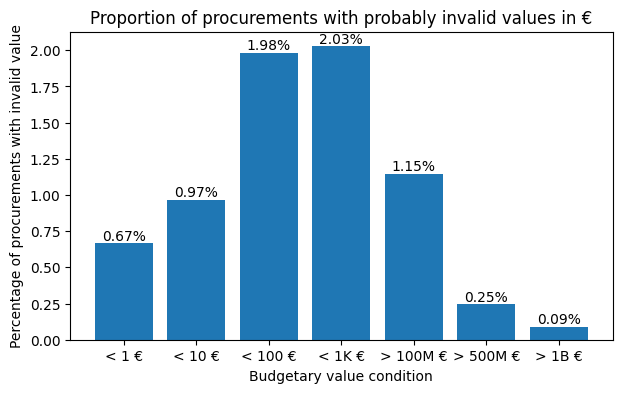

In [136]:
def notice_count_with_value_lower_than(value: float) -> int:
    return (reduce(lambda a, b: a | b, [
        proc_df[f].apply(lambda l: bool(l) and any(float(i.value) < value and i.currency == "EUR" for i in l))
        for f in value_fields
    ]) | reduce(lambda a, b: a | b, [
        proc_df[f].apply(lambda l: bool(l) and any(float(i.high.value) < value and i.high.currency == "EUR" for i in l))
        for f in range_fields
    ]) | reduce(lambda a, b: a | b, [
        proc_df[f].apply(lambda l: bool(l) and any(
            any(float(v.value) < value and v.currency == "EUR" for v in i.values)
            for i in l
        ))
        for f in object_value_fields
    ]) | reduce(lambda a, b: a | b, [
        proc_df[f].apply(lambda l: bool(l) and any(
            float(i.ranges.high.value or "0") < value and i.ranges.high.currency == "EUR"
            for i in l
        ))
        for f in object_range_fields
    ])).sum()


def notice_count_with_value_greater_than(value: float) -> int:
    return (reduce(lambda a, b: a | b, [
        proc_df[f].apply(lambda l: bool(l) and any(float(i.value) > value and i.currency == "EUR" for i in l))
        for f in value_fields
    ]) | reduce(lambda a, b: a | b, [
        proc_df[f].apply(lambda l: bool(l) and any(float(i.low.value) > value and i.low.currency == "EUR" for i in l))
        for f in range_fields
    ]) | reduce(lambda a, b: a | b, [
        proc_df[f].apply(lambda l: bool(l) and any(
            any(float(v.value) > value and v.currency == "EUR" for v in i.values)
            for i in l
        ))
        for f in object_value_fields
    ]) | reduce(lambda a, b: a | b, [
        proc_df[f].apply(lambda l: bool(l) and any(
            float(i.ranges.low.value or "0") > value and i.ranges.low.currency == "EUR"
            for i in l
        ))
        for f in object_range_fields
    ])).sum()


total_count = len(proc_df[present_value_count > 0])
notice_count = {
    '< 1 €': 100 * notice_count_with_value_lower_than(1) / total_count,
    '< 10 €': 100 * notice_count_with_value_lower_than(10) / total_count,
    '< 100 €': 100 * notice_count_with_value_lower_than(100) / total_count,
    '< 1K €': 100 * notice_count_with_value_lower_than(1000) / total_count,
    '> 100M €': 100 * notice_count_with_value_greater_than(100000000) / total_count,
    '> 500M €': 100 * notice_count_with_value_greater_than(500000000) / total_count,
    '> 1B €': 100 * notice_count_with_value_greater_than(1000000000) / total_count,
}
plt.figure(figsize=(7, 4))
rects = plt.bar(notice_count.keys(), notice_count.values())
plt.bar_label(rects, fmt='%.2f%%')
plt.xticks(rotation=0)
plt.title("Proportion of procurements with probably invalid values in €")
plt.xlabel("Budgetary value condition")
plt.ylabel("Percentage of procurements with invalid value")
plt.show()

In [137]:
def flatten(list_: list[list]) -> list:
    return [j for i in list_ for j in i]


def all_values(field: str, min_: float, max_: float, with_lots: float):
    if field in value_fields:
        values = proc_df[field].apply(
            lambda l: [float(i.value) for i in l if i.currency == "EUR" and min_ <= float(i.value) <= max_]
        )
    elif field in range_fields:
        values = proc_df[field].apply(
            lambda l: [
                          float(i.low.value)
                          for i in l
                          if i.low.currency == "EUR" and min_ <= float(i.low.value) <= max_
                      ]
                      + [
                          float(i.high.value)
                          for i in l
                          if i.high.currency == "EUR" and min_ <= float(i.high.value) <= max_
                      ]
        )
    elif field in object_value_fields:
        values = proc_df[field].apply(
            lambda l: flatten([
                [float(v.value) for v in i.values if v.currency == "EUR" and min_ <= float(v.value) <= max_]
                for i in l
                if (i.lot_id is None or with_lots)
            ])
        )
    else:
        values = proc_df[field].apply(
            lambda l: [
                          float(r.ranges.low.value or "0")
                          for r in l
                          if
                          r.ranges.low.currency == "EUR"
                          and min_ <= float(r.ranges.low.value) <= max_ and (r.lot_id is None or with_lots)
                      ] + [
                          float(r.ranges.high.value or "0")
                          for r in l
                          if r.ranges.high.currency == "EUR"
                             and min_ <= float(r.ranges.high.value) <= max_ and (r.lot_id is None or with_lots)
                      ]
        )
    return flatten(values)

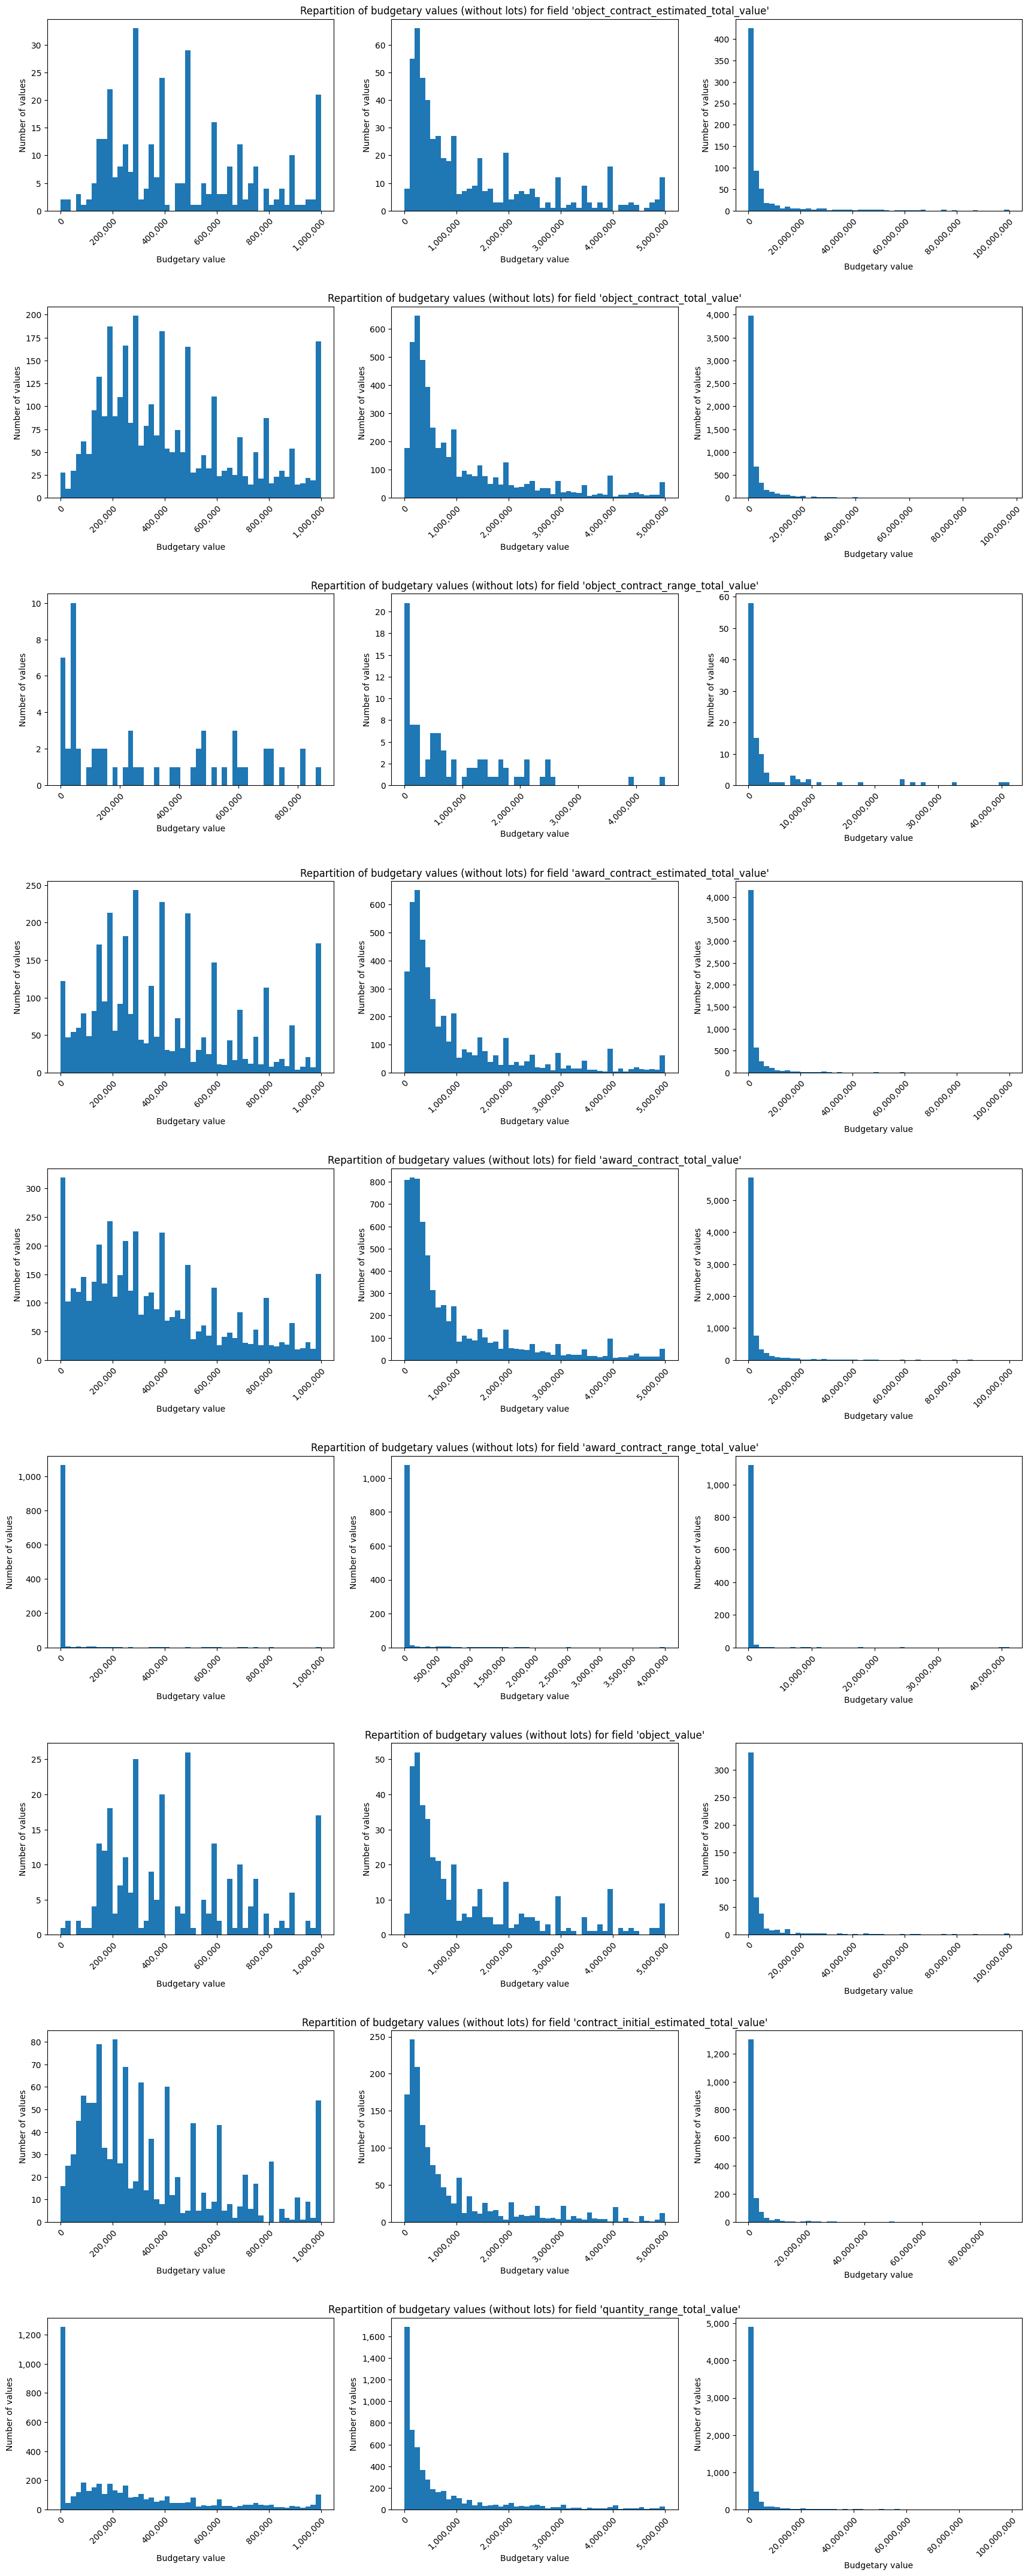

In [138]:
params = [
    (c, r)
    for c in proc_df.columns if c.endswith("_value")
    for r in ((0, 1000000), (0, 5000000), (0, 100000000))
]
width_figure_count = 3
height_figure_count = math.ceil(len(params) / width_figure_count)

gs = GridSpec(height_figure_count, width_figure_count)
plt.figure(figsize=(width_figure_count * 7, height_figure_count * 6))
plt.subplots_adjust(hspace=0.5)
for fig_id, (field, (min_, max_)) in enumerate(params):
    values = all_values(field, min_, max_, with_lots=False)
    plt.subplot(gs[int(fig_id / width_figure_count), int(fig_id % width_figure_count)])
    plt.hist(values, bins=50)
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{int(x):,.0f}"))
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f"{y:,.0f}"))
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    if fig_id % 3 == 1:
        plt.title(f"Repartition of budgetary values (without lots) for field '{field}'")
    plt.xlabel("Budgetary value")
    plt.ylabel("Number of values")
plt.show()

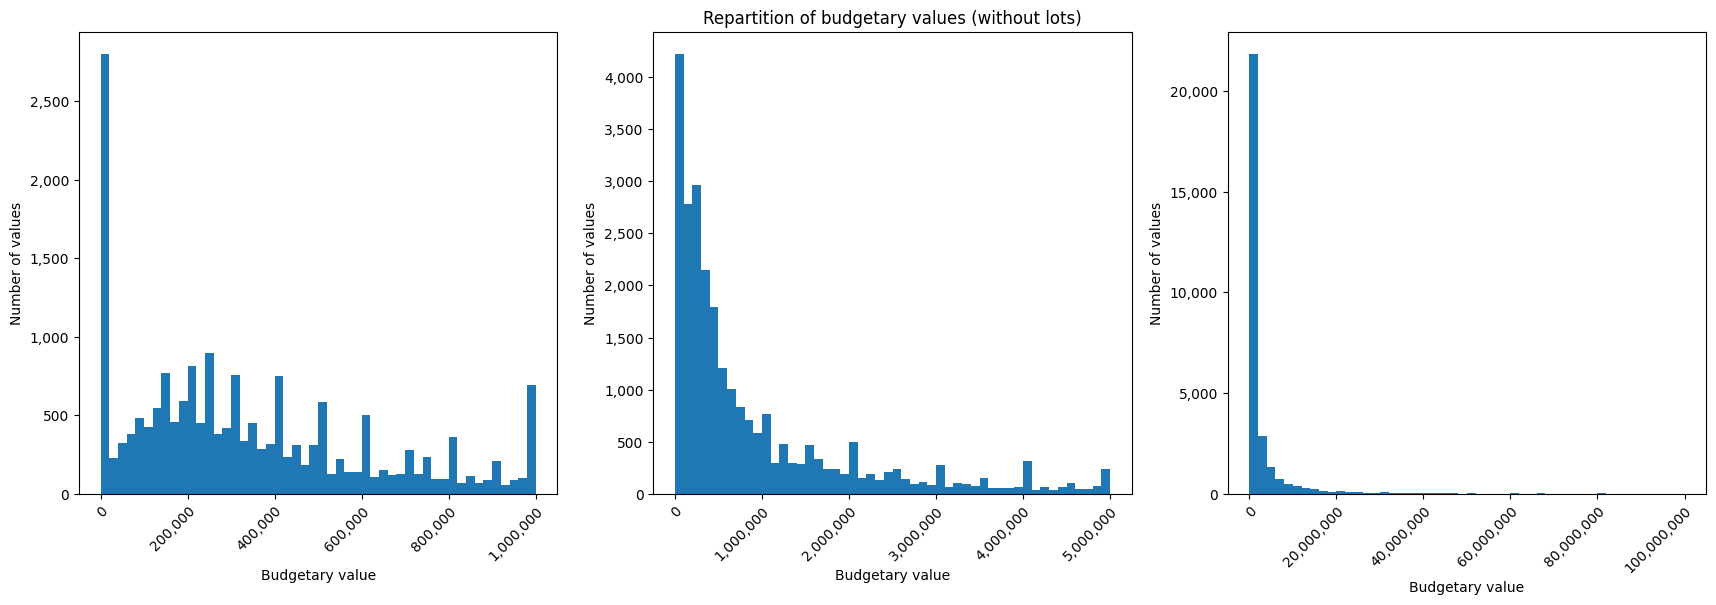

In [139]:
params = ((0, 1000000), (0, 5000000), (0, 100000000))
width_figure_count = 3
height_figure_count = math.ceil(len(params) / width_figure_count)

gs = GridSpec(height_figure_count, width_figure_count)
plt.figure(figsize=(width_figure_count * 7, height_figure_count * 6))
plt.subplots_adjust(hspace=0.5)
for fig_id, (min_, max_) in enumerate(params):
    values = flatten([
        all_values(c, min_, max_, with_lots=False)
        for c in proc_df.columns if c.endswith("_value")
    ])
    plt.subplot(gs[int(fig_id / width_figure_count), int(fig_id % width_figure_count)])
    plt.hist(values, bins=50)
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x:,.0f}"))
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f"{y:,.0f}"))
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    if fig_id % 3 == 1:
        plt.title(f"Repartition of budgetary values (without lots)")
    plt.xlabel("Budgetary value")
    plt.ylabel("Number of values")
plt.show()

### Mismatching between value fields

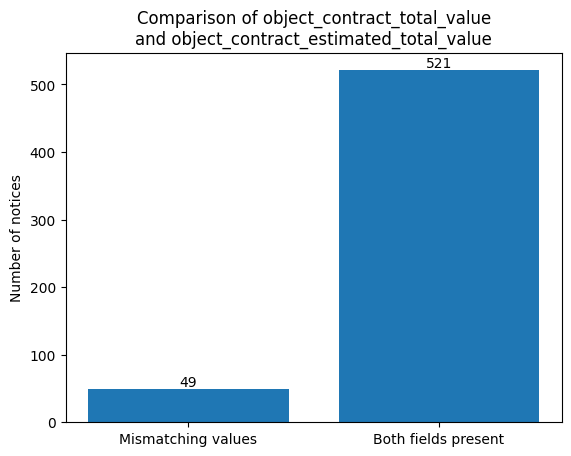

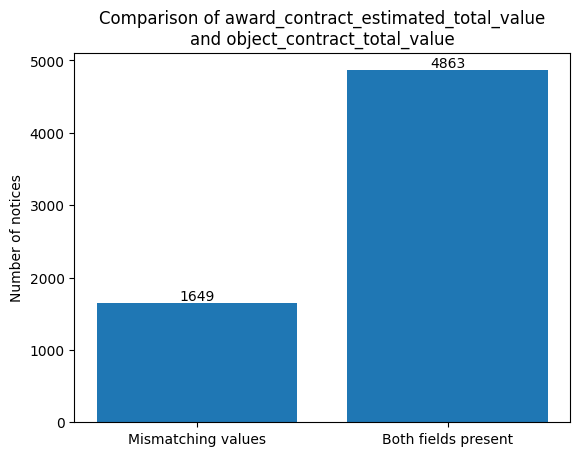

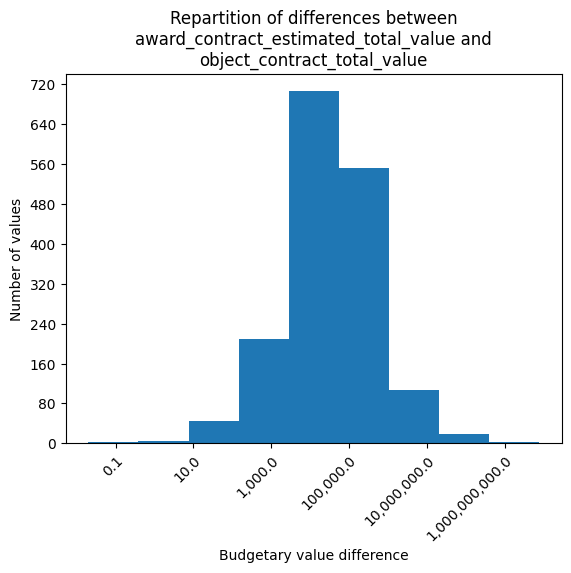

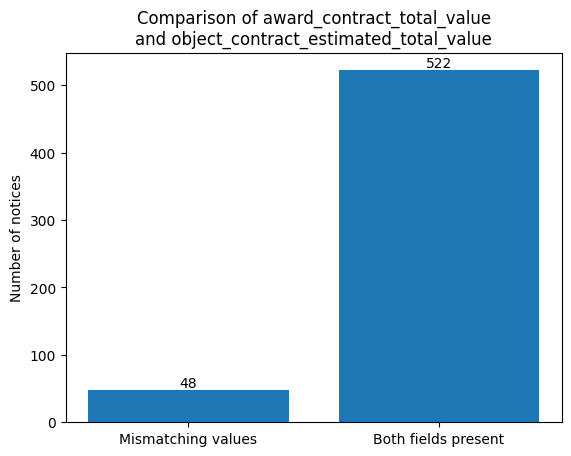

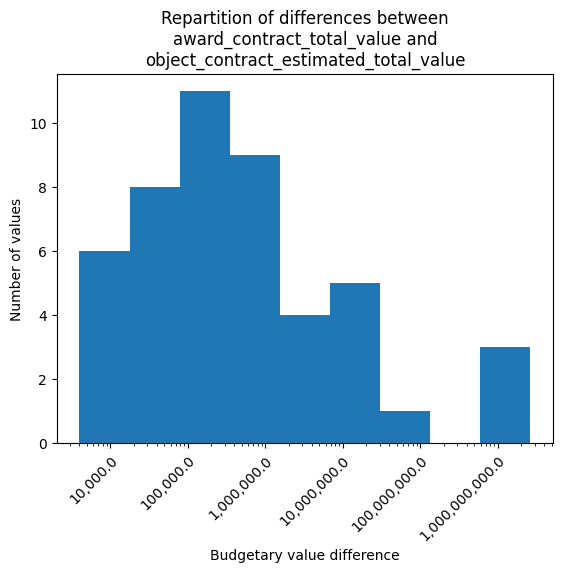

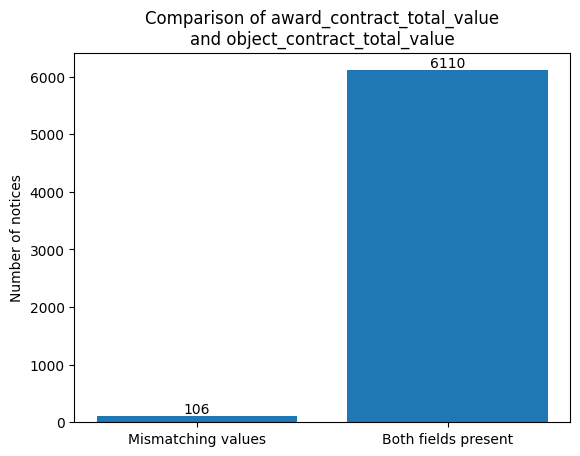

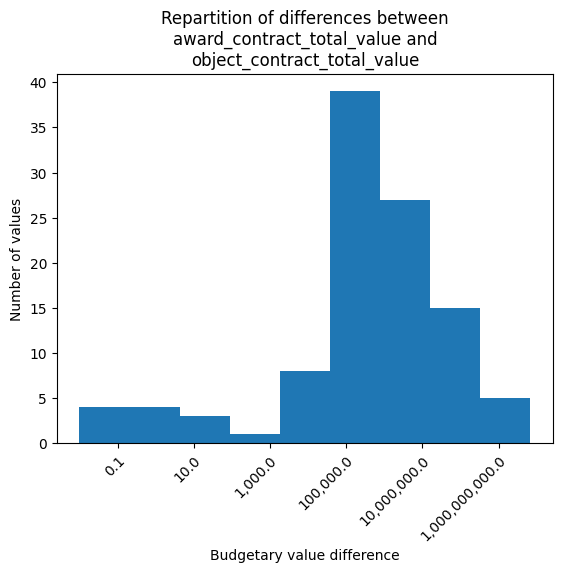

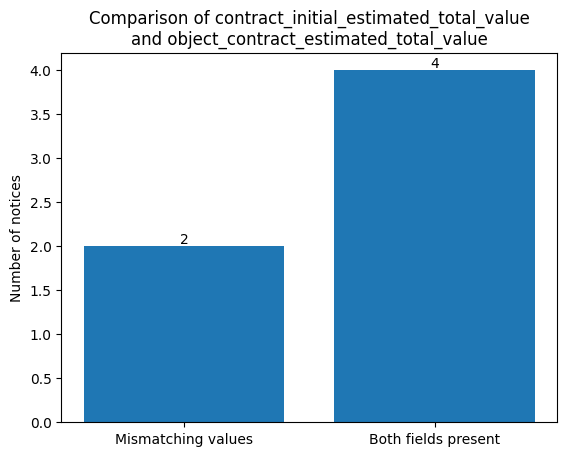

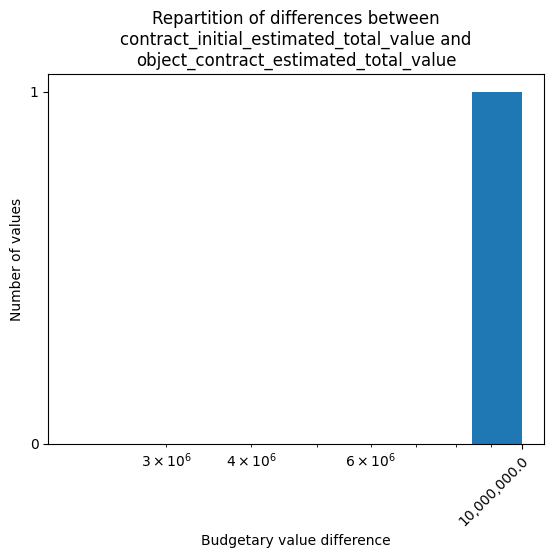

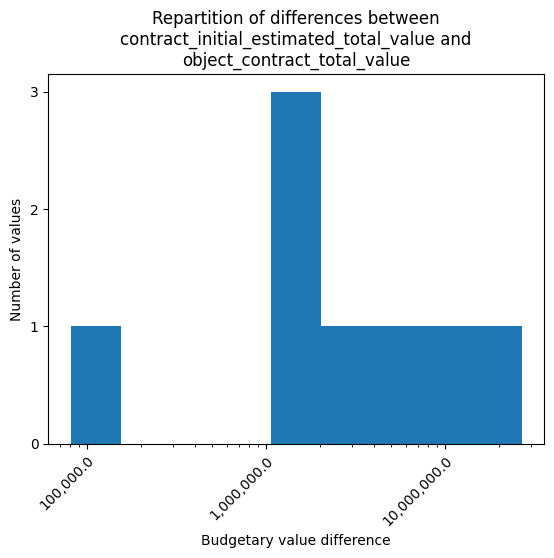

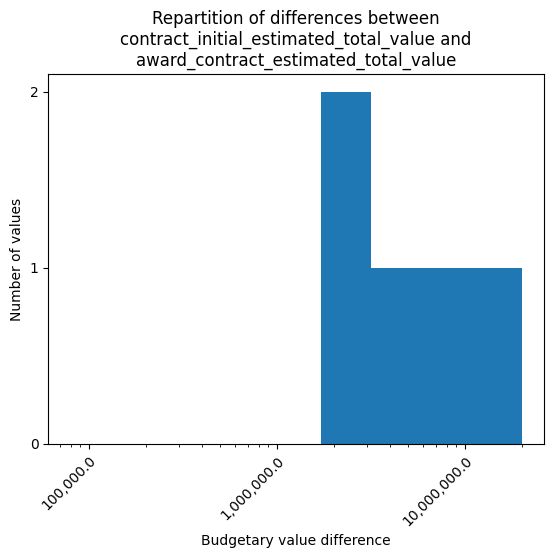

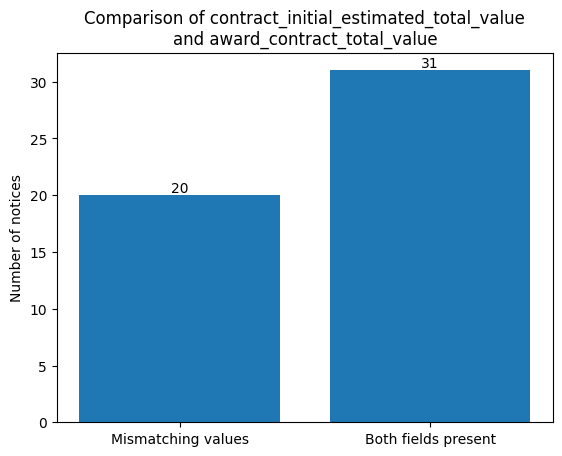

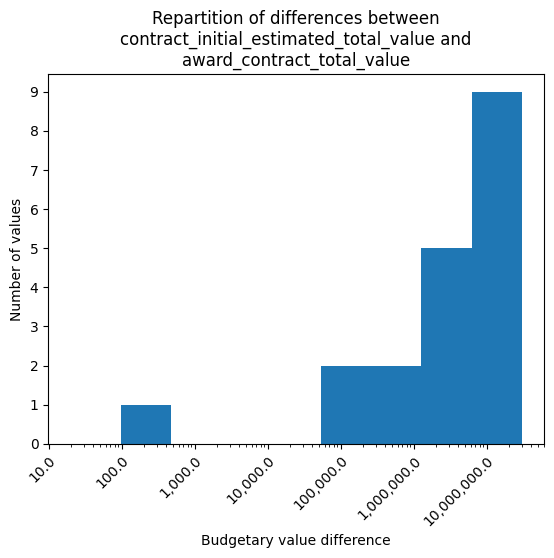

In [140]:
params = [(f1, f2) for i1, f1 in enumerate(value_fields) for i2, f2 in enumerate(value_fields) if i2 < i1]

for f1, f2 in params:
    proc_df["total_1"] = proc_df[f1].apply(lambda l: sum(float(v.value) for v in l))
    proc_df["total_2"] = proc_df[f2].apply(lambda l: sum(float(v.value) for v in l))
    results = {
        f"Mismatching values": (
                ((proc_df["total_1"] - proc_df["total_2"]) > 0.001)
                & (proc_df["total_1"] != 0)
                & (proc_df["total_2"] != 0)).sum(),
        "Both fields present": ((proc_df["total_1"] != 0) & (proc_df["total_2"] != 0)).sum(),
    }
    if results["Both fields present"] == 0:
        continue
    rects = plt.bar(results.keys(), results.values())
    plt.bar_label(rects)
    plt.title(f"Comparison of {f1}\nand {f2}")
    plt.ylabel("Number of notices")
    plt.show()

    wrong_lines = proc_df[((proc_df["total_1"] - proc_df["total_2"] > 0.001)
                           & (proc_df["total_1"] != 0) & (proc_df["total_2"] != 0))].copy()
    wrong_lines["diff_str"] = (wrong_lines["total_1"]
                               - wrong_lines["total_2"]).abs().apply(lambda d: f"{d:.2f}")
    values = wrong_lines["diff_str"].apply(float)
    plt.hist(values, bins=np.logspace(np.log10(values.min()), np.log10(values.max()), 10))
    plt.xscale('log')
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: f"{x:,.1f}"))
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f"{y:,.0f}"))
    plt.gca().yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
    plt.title(f"Repartition of differences between\n{f1} and\n{f2}")
    plt.xlabel("Budgetary value difference")
    plt.ylabel("Number of values")
    plt.show()